This is a demonstration of a 2-D CNN used for Image Classification

In [ ]:
import torch

from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


import math
import matplotlib.pyplot as plt

gpu_available = torch.cuda.is_available()
print(f'{gpu_available=}')

Using cuda


In [2]:
import sys
sys.path.append('../../')

from CustomDL.utils import train_model, test_model

# Load MNIST dataset

In [3]:
digits_dataset = MNIST(
    root='./data/MNIST', # the folder where data eixsts/is stored,
    download=True,
    transform=ToTensor() # The image are PIL format, this transform to Tensor objects
)
print(digits_dataset.data.shape)

train_data, test_data = random_split(digits_dataset, [.8, .2])

torch.Size([60000, 28, 28])


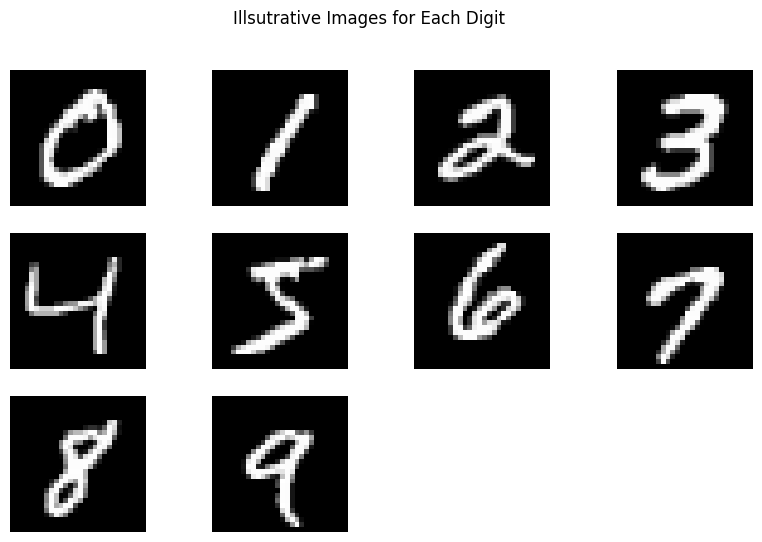

In [4]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
fig.suptitle('Illsutrative Images for Each Digit')

labels = digits_dataset.targets
num_lab = torch.tensor(labels.unique().shape[0])
rows = int(torch.sqrt(num_lab))
cols = int(torch.ceil(num_lab / rows))
for tens_number in labels.unique():
  number = tens_number.item()
  idx = torch.argmax((labels == number).int())
  img = digits_dataset[idx][0].squeeze()

  ax = fig.add_subplot(rows, cols, number + 1)
  ax.axis('off')
  ax.imshow(img, cmap='gray')

# Convolutional Network Definition

In [5]:
class ConvolutionLayer(nn.Module):
    def __init__(self,
        in_chan: int,
        out_chan: int,
        activation_fn: nn.Module,
        kern_size: int = 3,
        pool_kern: int = 2
    ):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_chan,
                out_channels=out_chan,
                kernel_size=kern_size,
                padding='same'
            ),
            activation_fn,
            nn.MaxPool2d(pool_kern)
        )

    def forward(self, in_data):
        return self.layer(in_data)

Assuming that every convolution operation preserves the shape of image, every convolutional layer results in a dimension reduction of `pool_kern_size` in the width and height.\
Hence, for a convolutional network with $n$ convolutional layers using pooling kernel sizes given by the set $\{k_1, k_2,\ldots,k_n\}$, the width and height of the image after feeding forward through all convolutional layer is:
$$
\text{width}' = \frac{\text{width}}{\prod_{i=1}^{i=n}k_i}
\qquad
\text{height}' = \frac{\text{height}}{\prod_{i=1}^{i=n}k_i}
$$

From this, we know the flattened input dimenion called in_features to the final Fully Connected Layer of the Convolutional Network to be:
$$
\text{in\_features} = 
\frac{\text{out\_channels} \cdot \text{width} \cdot \text{height}}{\left(\prod_{i=1}^{i=n}k_i\right)^2}
$$
In the case that all pooling kernel sizes are equal to $k$, we obtain a simpler form:
$$
\text{in\_features} = 
\frac{\text{out\_channels} \cdot \text{width} \cdot \text{height}}{k ^ {2n}}
$$

In [ ]:
# Here we define the network functionally. The network will contain two ConvolutionLayer with
# pool_kern_size of 2

in_features = 4 * 28 * 28 // (2 ** (2 * 2))
conv_net = nn.Sequential(
    ConvolutionLayer(1, 32, nn.ReLU()),
    ConvolutionLayer(32, 4, nn.ReLU()),

    nn.Flatten(),
    nn.Linear(in_features, 100), nn.ReLU(),
    nn.Linear(100, 100), nn.ReLU(),
    nn.Linear(100, 10)
)
if gpu_available:
    conv_net = conv_net.cuda()

# Training and Evaluation

In [ ]:
def run_epochs(
    epochs: int,
    model: nn.Module,
    train_loader: tuple[DataLoader, DataLoader],
    test_loader: tuple[DataLoader, DataLoader],
    loss_fn: nn.Module,
    optimizer: nn.Module
):
    num_dig = int(math.log10(epochs)) + 1
    update_rate = 1 if epochs <= 20 else 10

    for epoch in range(epochs):
        if not epoch % update_rate:
            print(f"Epoch {epoch + 1:>{num_dig}}/{epochs}", end=' || ')
        train_model(model, train_loader, loss_fn, optimizer,
                    use_gpu=gpu_available)
        loss, acc = test_model(model, test_loader, loss_fn, True,
                               use_gpu=gpu_available)
        if not epoch % update_rate:
            print(f"Average Loss: {loss:.6f} | {acc * 100:.4f}%")

In [11]:
batch_size = 64
learning_rate = 0.002

trainloader = DataLoader(train_data, batch_size, shuffle=True)
testloader = DataLoader(test_data, shuffle=True)

cross_entrop = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_net.parameters(), learning_rate)

In [12]:
epochs = 10
run_epochs(
    10, conv_net,
    trainloader, testloader,
    cross_entrop,
    optimizer
)

Epoch  1/10 || Average Loss: 2.301178 | 10.1750%
Epoch  2/10 || Average Loss: 2.292075 | 14.4917%
Epoch  3/10 || Average Loss: 2.268074 | 34.9333%
Epoch  4/10 || Average Loss: 2.173733 | 42.1250%
Epoch  5/10 || Average Loss: 1.440638 | 65.0250%
Epoch  6/10 || Average Loss: 0.700319 | 79.5167%
Epoch  7/10 || Average Loss: 0.500197 | 85.7417%
Epoch  8/10 || Average Loss: 0.409876 | 87.9417%
Epoch  9/10 || Average Loss: 0.364444 | 88.9917%
Epoch 10/10 || Average Loss: 0.337547 | 89.9000%


# Interpreting the Weights

In [ ]:
conv_net.eval()
layers = list(conv_net.children())

We observe the information extracted in each filters after the two convolutional layers.

In [ ]:
number = 5
indices = (test_data.targets == number).argwhere()

sample_image = test_data[indices[0].item()][0]
sample_image.shape
convolved_input = layers[1](layers[0](sample_image))


cmap = 'gray_r'
layout = [
  ['Image', 0, 1],
  ['Image', 2, 3]
]

fig = plt.figure(figsize=(10, 5))
axes = fig.subplot_mosaic(layout, width_ratios=(2, 1, 1))

axes['Image'].imshow(sample_image[0, :, :], cmap=cmap)
axes['Image'].set_title('Original Image')
axes['Image'].set_xticks([])
axes['Image'].set_yticks([])
for i in range(4):
  axes[i].set_title(f'Filter {i}')
  axes[i].imshow(convolved_input[i, :, :], cmap=cmap)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

# Inference on unseen data

We already observed how well the model can infer unseen images from the test set.\
One thing we notice is that these images are all 28x28 images. So any new images of different size
can not be predicted by the model.

To solve this issue, we need to change the dimension of the image in some way without losing too much information. For an image with a smaller size than the original 28x28, we can simply add black pixels to the image, which does not add in any unnecessary information to the original image. However, images of larger sizes requires a more contrived method.\
Here, we try the following method of compression the image:
1. Blurring images using Gaussian Blur: This is essentially a 2d Convolution on the image where we use a fixed Gaussian kernel instead of a learned kernel. This acts as a low-pass filter where high/rapid changes in colour gets smoothed out.
2. Downsampling the image respectively in the row and width.

Furthermore, to easily determine the kernel size for blurring to compress into 28x28 image. We will first 'square' the image by zero-padding the suitable dimension.

Note that instead of using a Gaussian kernel for the convolution, we can use a different kernel like a Box kernel, Hanning kernel, etc.

In [2]:
import torchvision

from torchvision.transforms import GaussianBlur

In [111]:
def compress_image(
    img: torch.Tensor,
    desired_shape: int
):
    if img.shape[1] != img.shape[2]:
        missing_dim = abs(img.shape[1] - img.shape[2])
        if img.shape[1] < img.shape[2]:
            new_img = nn.functional.pad(img, (0, 0, 0, missing_dim))
        else:
            new_img = nn.functional.pad(img, (0, missing_dim, 0, 0))

    if img.shape[1] == desired_shape:
        return new_img

    # Gaussian Blur, the kernel size of 1/4 the image size is taken
    # Note that kernel size must be odd
    kern_size = new_img.shape[1] // 4
    if kern_size % 2 == 0: kern_size += 1
    new_img = GaussianBlur(kern_size, 5)(new_img)

    # downsample image to best match the desired_shape
    # this however does not ensure a perfect match, so we need to
    # crop out the extra rows and columns afterwards.
    down_sr = new_img.shape[1] // desired_shape
    new_img = new_img[:, ::down_sr, ::down_sr]

    if new_img.shape != (1, 28, 28):
        extra_dims = new_img.shape[1] - 28
        new_img = new_img[:, :-extra_dims, :-extra_dims]    
    return new_img

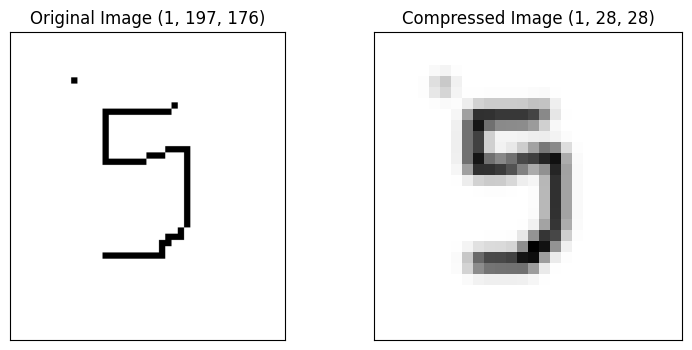

In [120]:
img = torchvision.io.read_image('./data/test_img/num5.png')
img = (img[0:1] - 255) / 255

lowpass_filtered_image = compress_image(img, 28)


fig = plt.figure(figsize=(9, 4))
axes = fig.subplots(1, 2)
axes[0].set_title(f'Original Image {tuple(img.shape)}')
axes[0].imshow(img[0], cmap='gray_r')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title(f'Compressed Image {tuple(lowpass_filtered_image.shape)}')
axes[1].imshow(lowpass_filtered_image[0], cmap='gray_r')
axes[1].set_xticks([]);
axes[1].set_yticks([]);

In [ ]:
# Reusing the layers extracted from the section above, remember to run those cells!
convolved_input = layers[1](layers[0](lowpass_filtered_image))


cmap = 'gray_r'
layout = [
  ['Image', 0, 1],
  ['Image', 2, 3]
]

fig = plt.figure(figsize=(10, 5))
axes = fig.subplot_mosaic(layout, width_ratios=(2, 1, 1))

axes['Image'].imshow(sample_image[0, :, :], cmap=cmap)
axes['Image'].set_title('Original Image')
axes['Image'].set_xticks([])
axes['Image'].set_yticks([])
for i in range(4):
  axes[i].set_title(f'Filter {i}')
  axes[i].imshow(convolved_input[i, :, :], cmap=cmap)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

In [ ]:
predict_vals = conv_net(lowpass_filtered_image)
predict_probs = nn.Softmax()(predict_vals)
prediction = predict_probs.argmax().item()

print(f"""Output Values:
    {predict_vals}
Predicted Probabilities:
    {predict_probs}
Prediction: {prediction}""")

# Saving Model

In [13]:
model_dict = {
    'model_dict': conv_net.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'epochs': epochs
}
torch.save(
    model_dict,
    './output/cnn_demo_3Layer_100Perc.pth'
)